# Serie temporal: predicción de ventas para TodoVentas S.A⚡️
Proyecto realizado por Alejandra Vaquero
<br><br>

## Introducción

**Objetivo**: predecir cuál será su nivel de ventas totales durante el próximo mes.

**Datos**: ventas diarias por producto en los mercados más importantes durante los últimos años. Se ha fijado un horizonte de predicción de un mes teniendo en cuenta la última fecha de transacciones disponible en los datos (el 9 de Diciembre de 2023).

**Metas del ejercicio**:
1. Construir una métrica adecuada para llevar a cabo la tarea utilizando los datos que se ofrecen así como seleccionar y justificar el modelo predictivo que mejor se ajuste al objetivo.
2. Elaborar un informe en formato notebook (ipynb) que muestre los aspectos más relevantes relacionados con la evolución de las ventas en TodoVentas S.A⚡️ durante el último ejercicio y las predicciones de ventas para el próximo mes.
<br>

### Librerías a utilizar

In [1]:
# imports base
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt

# series temporales
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from prophet import Prophet
from prophet.plot import plot_cross_validation_metric, plot, plot_components

from sktime.forecasting.model_selection import temporal_train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import XGBRegressor


## 1. Preprocesamiento: Análisis descriptivo

### Cargar y explorar los datos

In [2]:
df = pd.read_csv('retail_todo_ventas.csv', sep=',')
df.head()

/var/folders/t0/kf4ls9ss5b12r0bynt2jdwgm0000gn/T/ipykernel_12558/789816405.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('retail_todo_ventas.csv', sep=',')


,InvoiceNo,StockCode,Date,Country,TotalSales
0,536365,21730,2022-12-01,United Kingdom,25.50
1,536365,22752,2022-12-01,United Kingdom,15.30
2,536365,71053,2022-12-01,United Kingdom,20.34
3,536365,84029E,2022-12-01,United Kingdom,20.34
4,536365,84029G,2022-12-01,United Kingdom,20.34


In [3]:
df.sort_values(by='Date', ascending=False).head()

,InvoiceNo,StockCode,Date,Country,TotalSales
393292,581492,21201,2023-12-09,United Kingdom,19.84
393560,581492,23103,2023-12-09,United Kingdom,6.58
393544,581492,23012,2023-12-09,United Kingdom,8.29
393545,581492,23013,2023-12-09,United Kingdom,16.58
393546,581492,23014,2023-12-09,United Kingdom,8.29


In [4]:
df.sort_values(by='Date', ascending=True).head()

,InvoiceNo,StockCode,Date,Country,TotalSales
0,536365,21730,2022-12-01,United Kingdom,25.50
1486,536562,72741,2022-12-01,United Kingdom,13.05
1485,536562,48194,2022-12-01,United Kingdom,15.90
1484,536562,48185,2022-12-01,United Kingdom,15.90
1483,536562,37449,2022-12-01,United Kingdom,19.90


In [5]:
paises = df['Country'].unique()
paises.tolist()

['United Kingdom',
 'France',
 'Netherlands',
 'Germany',
 'EIRE',
 'Spain',
 'Portugal',
 'Italy',
 'Belgium',
 'Sweden']

In [6]:
df.shape
# (394330, 5)

(394330, 5)

In [7]:
df.describe(include='all')

,InvoiceNo,StockCode,Date,Country,TotalSales
count,394330.0,394330,394330,394330,394330.000000
unique,19302.0,3697,305,10,NaN
top,573585.0,85123A,2023-12-05,United Kingdom,NaN
freq,833.0,2168,3898,367325,NaN
mean,NaN,NaN,NaN,NaN,24.488495
std,NaN,NaN,NaN,NaN,103.726861
min,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,7.380000
50%,NaN,NaN,NaN,NaN,13.520000
75%,NaN,NaN,NaN,NaN,19.900000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394330 entries, 0 to 394329
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   InvoiceNo   394330 non-null  object 
 1   StockCode   394330 non-null  object 
 2   Date        394330 non-null  object 
 3   Country     394330 non-null  object 
 4   TotalSales  394330 non-null  float64
dtypes: float64(1), object(4)
memory usage: 15.0+ MB


Este archivo contiene 394.330 registros de transacciones de ventas, entre las fechas 1 de diciembre de 2022 hasta el 9 de diciembre del 2023.

Los países representados son 10: 'United Kingdom', 'France', 'Netherlands', 'Germany', 'EIRE', 'Spain', 'Portugal', 'Italy', 'Belgium', 'Sweden'.

Tiene cinco columnas que contienen las siguiente variables:

1. `InvoiceNo`: Número de factura (convertir a 'string').
2. `StockCode`: Código del producto (convertir a 'string').
3. `Date`: Fecha de la transacción (texto, requiere conversión a formato 'datetime' aaaa-mm-dd).
4. `Country`: País de la transacción (convertir a 'category').
5. `TotalSales`: Ventas totales por transacción (numérico, decimales 'float').

Notas:
- No existen datos nulos en el dataset.
- Existe una distribución de los datos sesgada hacia la derecha, ya que la media es mayor que la mediana en la columna de ventas o 'TotalSales', hay posibles outliers.

In [9]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['InvoiceNo'] = df['InvoiceNo'].astype('string')
df['StockCode'] = df['StockCode'].astype('string')
df['Country'] = df['Country'].astype('category')

df.dtypes

InvoiceNo     string[python]
StockCode     string[python]
Date          datetime64[ns]
Country             category
TotalSales           float64
dtype: object

In [10]:
# Generar un marco temporal completo desde la fecha mínima hasta la máxima
rango_fechas = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
rango_fechas

DatetimeIndex(['2022-12-01', '2022-12-02', '2022-12-03', '2022-12-04',
               '2022-12-05', '2022-12-06', '2022-12-07', '2022-12-08',
               '2022-12-09', '2022-12-10',
               ...
               '2023-11-30', '2023-12-01', '2023-12-02', '2023-12-03',
               '2023-12-04', '2023-12-05', '2023-12-06', '2023-12-07',
               '2023-12-08', '2023-12-09'],
              dtype='datetime64[ns]', length=374, freq='D')

In [11]:
# Verificar los días faltantes por país
faltantes_por_pais = {}
for pais in paises:
    datos_pais = df[df['Country'] == pais].set_index('Date')
    dias_faltantes = rango_fechas.difference(datos_pais.index)
    faltantes_por_pais[pais] = len(dias_faltantes)

faltantes_por_pais

{'United Kingdom': 69,
 'France': 168,
 'Netherlands': 313,
 'Germany': 174,
 'EIRE': 213,
 'Spain': 298,
 'Portugal': 328,
 'Italy': 343,
 'Belgium': 291,
 'Sweden': 342}

Se realizó el ejercicio con interpolación de datos lineales. Al completar la información diaria con una interpolación lineal se aumenta hasta casi en un 20% las ventas en algunos países, lo que altera significativamente los resultados de las ventas totales. Se decide no imputar los días y datos faltantes para mantener la fidelidad de los datos originales.

In [12]:
# Agrupar los datos para consolidar las ventas diarias por país y fecha
ventas_agrupadas = df.groupby(['Country', 'Date'], observed=False)['TotalSales'].sum().reset_index()
ventas_agrupadas.head()

,Country,Date,TotalSales
0,Belgium,2022-12-01,0.0
1,Belgium,2022-12-02,0.0
2,Belgium,2022-12-03,304.9
3,Belgium,2022-12-05,0.0
4,Belgium,2022-12-06,0.0


### Variables temporales y estacionalidad

#### Análisis global (todos los países)

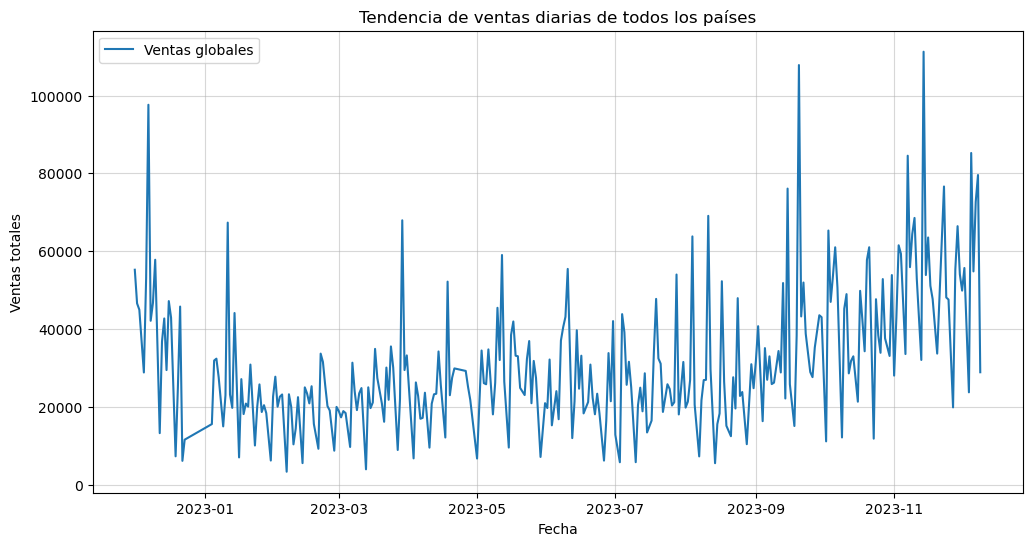

In [13]:
ventas_globales = ventas_agrupadas.groupby('Date')['TotalSales'].sum().reset_index()

# Visualizar las tendencias globales
plt.figure(figsize=(12, 6))
plt.plot(ventas_globales['Date'], ventas_globales['TotalSales'], label='Ventas globales')
plt.title('Tendencia de ventas diarias de todos los países')
plt.xlabel('Fecha')
plt.ylabel('Ventas totales')
plt.grid(True, alpha=0.5)
plt.legend()
plt.show()

Se puede observar la evolución diaria de las ventas totales combinadas de los 10 países. Se observan algunos picos, denotando momentos de promociones o temporadas altas. Es posible que exista estacionaliad mensual o semanal pero lo evaluaremos en una descomposición de componentes de la serie temporal.

#### Países más representativos

In [14]:
# Identificar los 3 países con mayores ventas totales
ventas_totales_pais = ventas_agrupadas.groupby('Country', observed=False)['TotalSales'].sum().sort_values(ascending=False).head(3)
top_paises = ventas_totales_pais.index.tolist()
top_paises

['United Kingdom', 'Netherlands', 'EIRE']

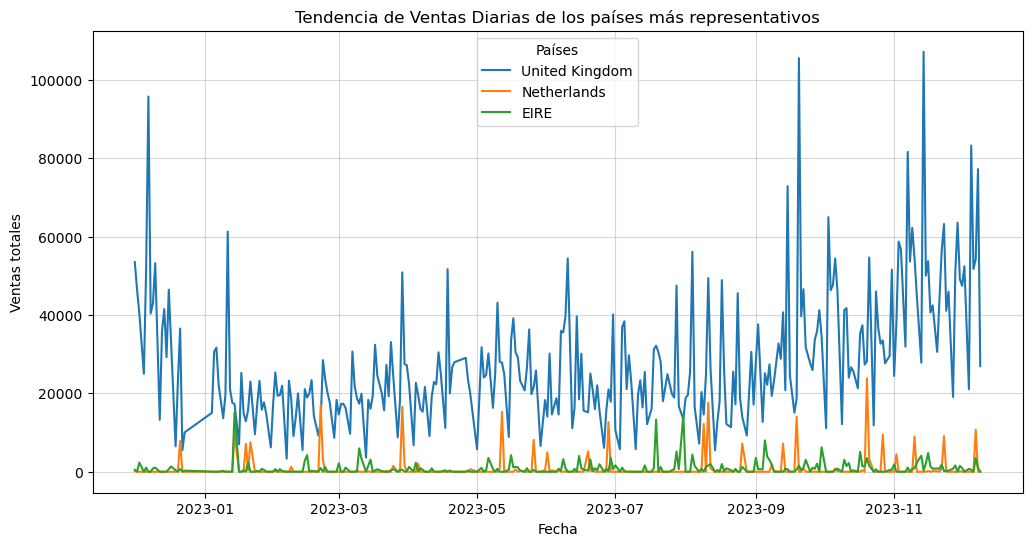

In [15]:
# Visualizar las tendencias generales de los 3 países con mayores ventas
plt.figure(figsize=(12, 6))

for pais in top_paises:
    datos_pais = ventas_agrupadas[ventas_agrupadas['Country'] == pais]
    plt.plot(datos_pais['Date'], datos_pais['TotalSales'], label=pais)

plt.title('Tendencia de Ventas Diarias de los países más representativos')
plt.xlabel('Fecha')
plt.ylabel('Ventas totales')
plt.grid(True, alpha=0.5)
plt.legend(title='Países')
plt.show()

Existe una gran diferencia entre el volumen de venta de cada uno de los países. Mientras unos países representan un comportamiento más estable otros presentan picos asociados probablemente a una estacionalidad.

### Descomposición de componentes de la serie temporal

Utilizaremos un periodo mensual ya que tenemos datos faltantes lo que nos impide realizar un buen análisis semanal y tampoco tenemos suficientes datos anuales para realizar un análisis de un periodo de 365 días.

#### Serie temporal global (todos los países)

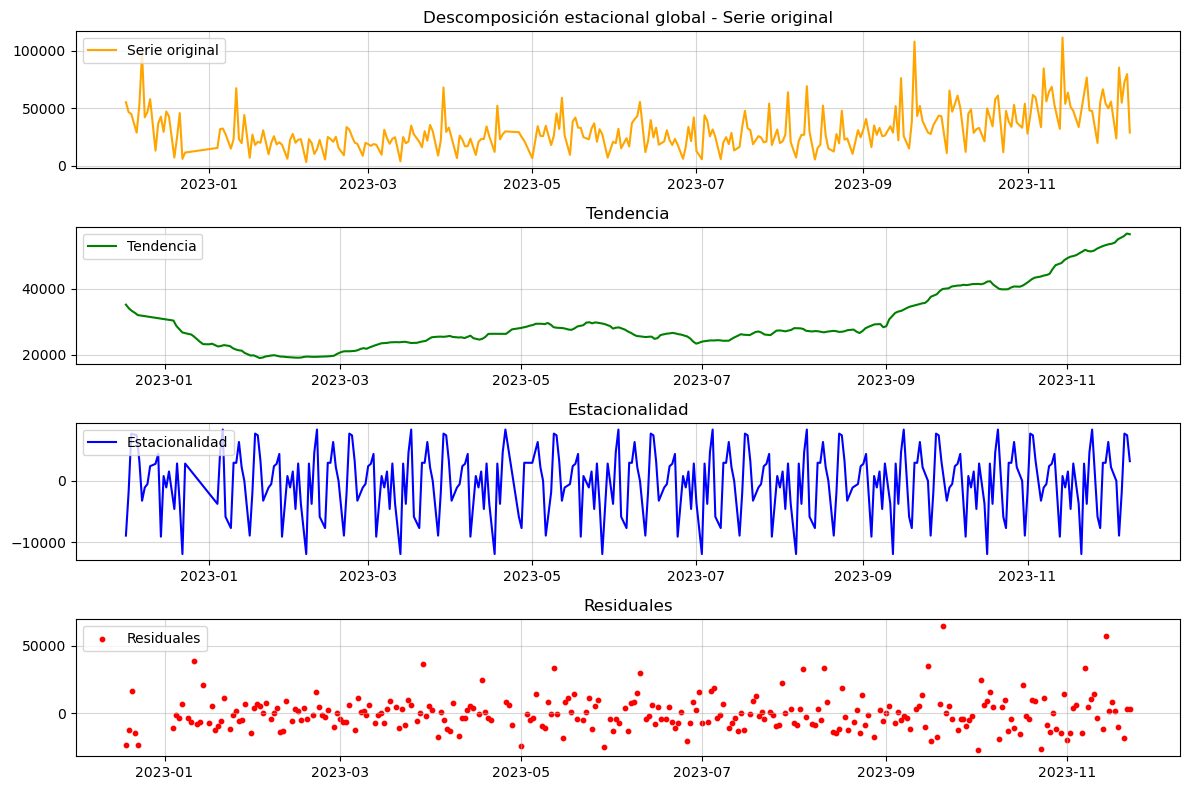

In [16]:
ventas_globales.set_index('Date', inplace=True)
descomposicion_global = seasonal_decompose(ventas_globales['TotalSales'], model='additive', period=30)

# Visualizar la descomposición
plt.figure(figsize=(12, 8))

# Serie original
plt.subplot(4, 1, 1)
plt.plot(descomposicion_global.observed, label='Serie original', color='orange')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.5)
plt.title('Descomposición estacional global - Serie original')

# Tendencia
plt.subplot(4, 1, 2)
plt.plot(descomposicion_global.trend, label='Tendencia', color='green')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.5)
plt.title('Tendencia')

# Estacionalidad
plt.subplot(4, 1, 3)
plt.plot(descomposicion_global.seasonal, label='Estacionalidad', color='blue')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.5)
plt.title('Estacionalidad')

# Residuales
plt.subplot(4, 1, 4)
plt.scatter(ventas_globales.index, descomposicion_global.resid, label='Residuales', color='red', s=10)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.5)
plt.title('Residuales')

plt.tight_layout()
plt.show()

En la serie original se observan picos prominentes y algunas fluctuaciones. En la tendencia se confirma un aumento de las ventas a final del año. Existe una estacionalidad aparentemente recurrente de manera mensual. En la gráfica de residuales podemos observar algunos eventos impredecibles o ruido.

#### Países más representativos

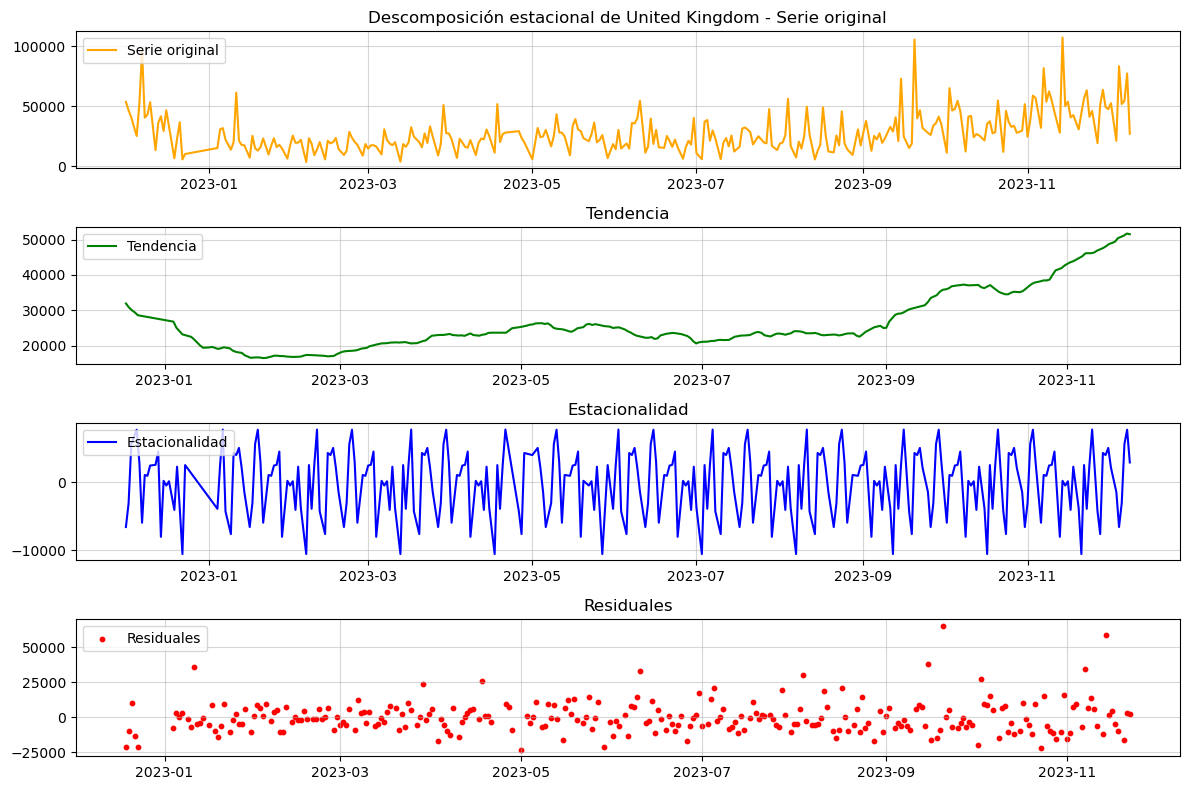

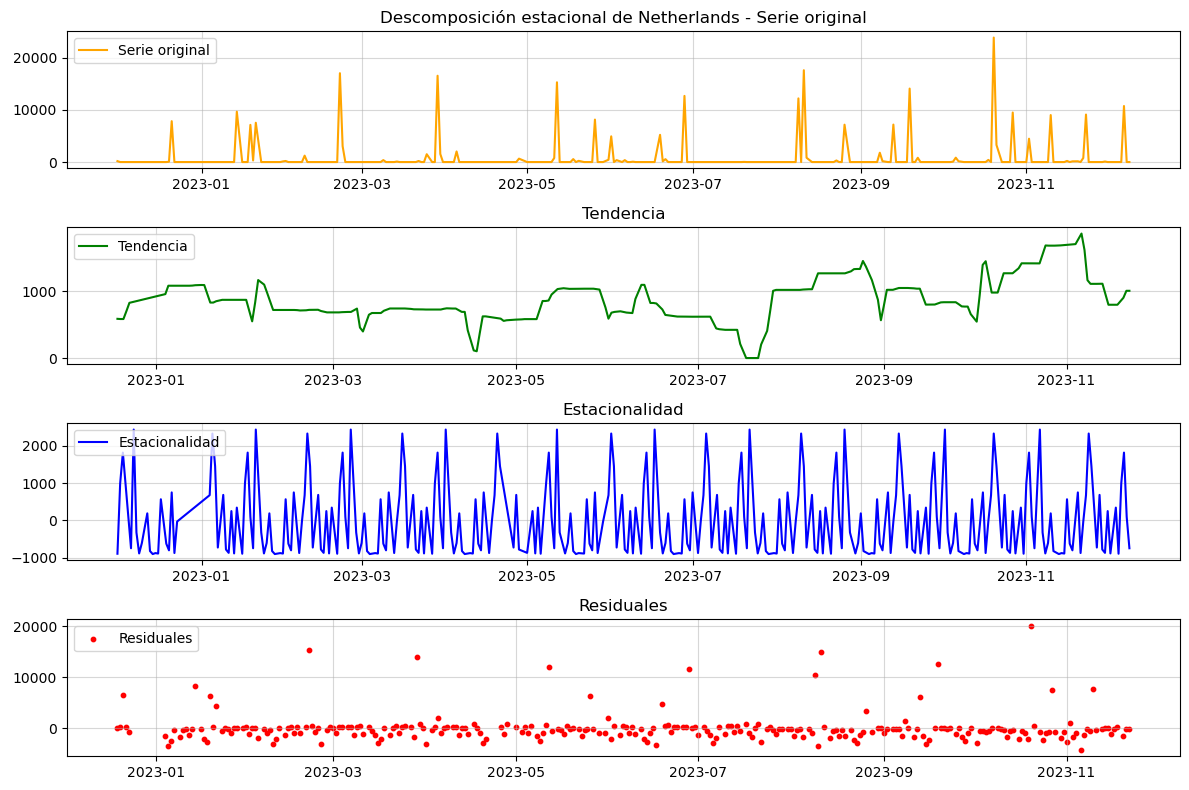

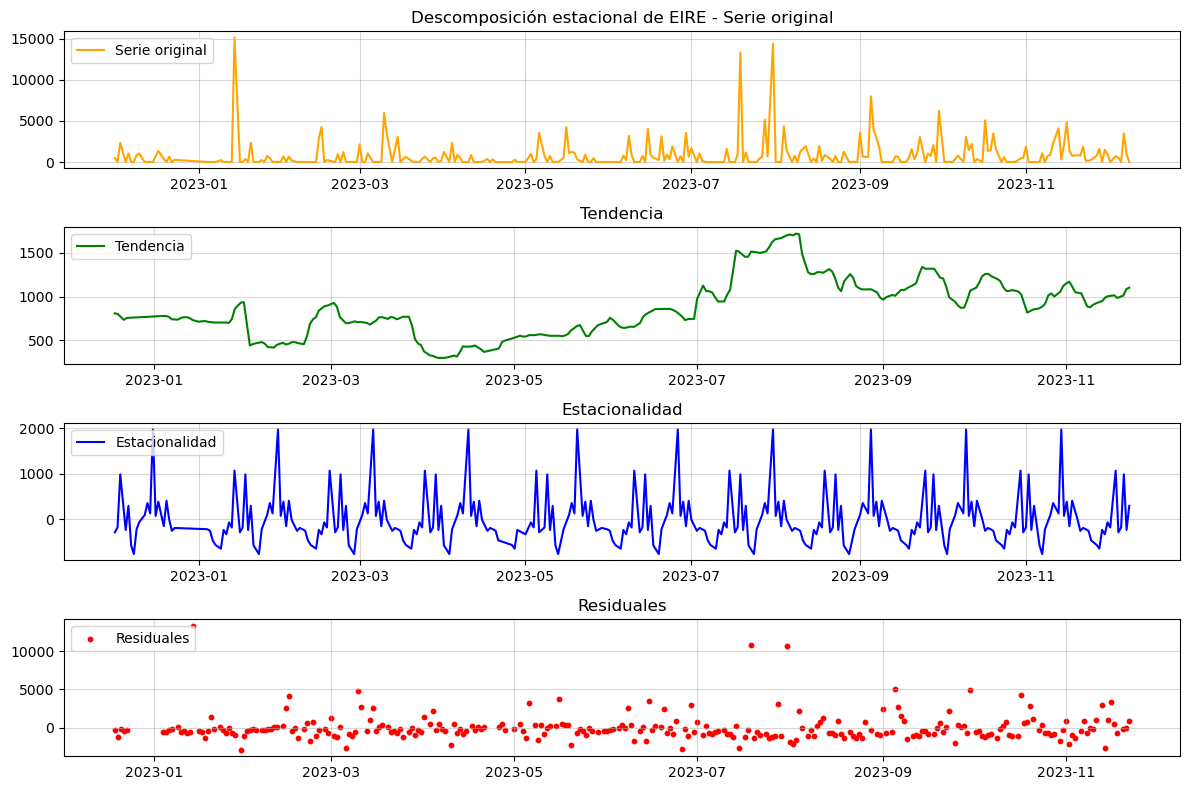

In [17]:
for pais in top_paises:
    datos_pais = ventas_agrupadas[ventas_agrupadas['Country'] == pais].set_index('Date')
    descomposicion = seasonal_decompose(datos_pais['TotalSales'], model='additive', period=30)

    # Guardar resultados
    resultados_paises = {}
    resultados_paises[pais] = descomposicion

    # Visualizar
    plt.figure(figsize=(12, 8))

    # Serie original
    plt.subplot(4, 1, 1)
    plt.plot(descomposicion.observed, label='Serie original', color='orange')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.5)
    plt.title(f'Descomposición estacional de {pais} - Serie original')

    # Tendencia
    plt.subplot(4, 1, 2)
    plt.plot(descomposicion.trend, label='Tendencia', color='green')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.5)
    plt.title('Tendencia')

    # Estacionalidad
    plt.subplot(4, 1, 3)
    plt.plot(descomposicion.seasonal, label='Estacionalidad', color='blue')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.5)
    plt.title('Estacionalidad')

    # Residuales
    plt.subplot(4, 1, 4)
    plt.scatter(datos_pais.index, descomposicion.resid, label='Residuales', color='red', s=10)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.5)
    plt.title('Residuales')

    plt.tight_layout()
    plt.show()

United Kingdom:
Parece una tendencia estable o positiva, reflejando su liderazgo en ventas totales. La estacionalidad muestra patrones mensuales.

Netherlands:
Las ventas pueden tener una tendencia más irregular, con picos en meses específicos. Los residuales muestran variabilidad debido a eventos únicos.

EIRE:
Las ventas reflejan una tendencia más fluctuante y los residuales, al igual que Netherlands, muestran variabilidad debido a eventos extraordinarios.

### Autocorrelación (ACF) y autocorrelación parcial (PACF)

#### Serie temporal global (todos los países)

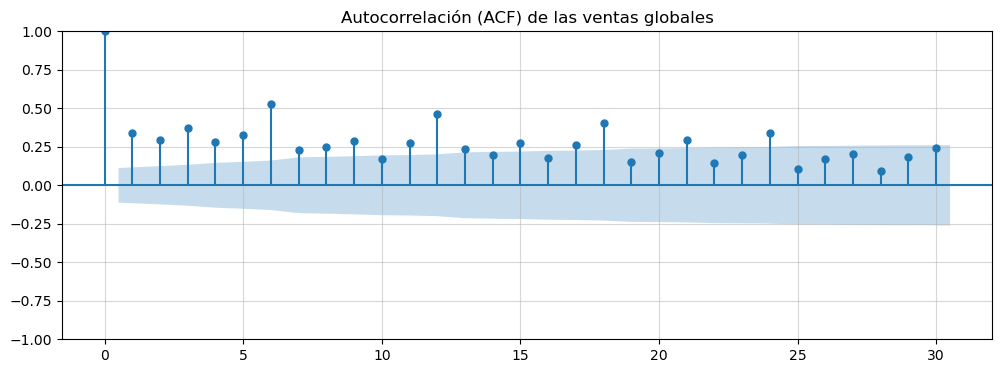

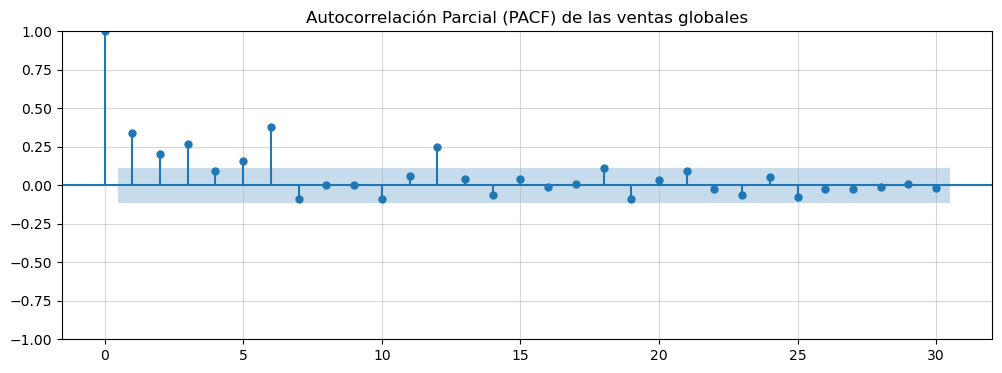

In [18]:
# Autocorrelación (ACF)
plt.figure(figsize=(12, 4))
plot_acf(ventas_globales['TotalSales'], lags=30, ax=plt.gca(), title='Autocorrelación (ACF) de las ventas globales')
plt.grid(True, alpha=0.5)
plt.show()

# Autocorrelación Parcial (PACF)
plt.figure(figsize=(12, 4))
plot_pacf(ventas_globales['TotalSales'], lags=30, ax=plt.gca(), title='Autocorrelación Parcial (PACF) de las ventas globales', method='ywm')
plt.grid(True, alpha=0.5)
plt.show()

La autocorrelación muestra una caída gradual en la correlación conforme aumenta el número de lags, lo que sugiere posibles patrones recurrentes (mensual) y picos en lags específicos (semanal).

La autocorrelación parcial muestra una disminución lo que indica una relación importante en los lags más cercanos. También se pueden percibir evento recurrentes.

In [19]:
# Evaluar si la serie temporal global es estacionaria
# Aplicar Dickey-Fuller test
resultado_global = adfuller(ventas_globales['TotalSales'])

print('p-value of the Dickey-Fuller test: %f' % resultado_global[1])

p-value of the Dickey-Fuller test: 0.666296


Como el p-valor es > 0.05 la serie no es estacionaria.

## 2. Desarrollo de Métodos

#### Serie temporal global (todos los países)

##### PROPHET
Prophet funciona mejor con series temporales que tienen efectos estacionales fuertes (ya sean semanales o mensuales) y una cantidad suficiente de datos históricos donde se representa esa estacionalidad. Prophet es robusto ante datos faltantes y cambios de tendencia, y tiende a manejar bien los valores atípicos.

In [20]:
datos_prophet = ventas_globales.reset_index()[['Date', 'TotalSales']].rename(columns={'Date': 'ds', 'TotalSales': 'y'})
datos_prophet.head()

,ds,y
0,2022-12-01,55235.64
1,2022-12-02,46590.54
2,2022-12-03,44955.28
3,2022-12-05,28829.70
4,2022-12-06,53075.60


In [21]:
# Dado que el horizonte de predicción es de 30 días, usar un conjunto de prueba de exactamente 30 días es más adecuado.
datos_train, datos_test = temporal_train_test_split(datos_prophet, test_size=30)
display(datos_train.shape, datos_train.head(2), datos_train.tail(2))
display(datos_test.shape, datos_test.head(2), datos_test.tail(2))

(275, 2)

,ds,y
0,2022-12-01,55235.64
1,2022-12-02,46590.54


,ds,y
273,2023-11-03,61512.43
274,2023-11-04,59347.73


(30, 2)

,ds,y
275,2023-11-06,33570.41
276,2023-11-07,84536.81


,ds,y
303,2023-12-08,79577.98
304,2023-12-09,28889.84


In [22]:
modelo_prophet = Prophet()
modelo_prophet.fit(datos_train)

13:28:48 - cmdstanpy - INFO - Chain [1] start processing
13:28:48 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
# Calcular los días necesarios para cubrir el test
ultima_train = datos_train['ds'].max() 
ultima_test = datos_test['ds'].max()
diferencia_dias = (ultima_test - ultima_train).days
diferencia_dias

35

In [24]:
# Generar el future Dataframe
futuro = modelo_prophet.make_future_dataframe(periods=35, freq='D')
display(futuro.shape, futuro.head(2), futuro.tail(2))

(310, 1)

,ds
0,2022-12-01
1,2022-12-02


,ds
308,2023-12-08
309,2023-12-09


In [25]:
# Generar predicciones para el próximo mes
predicciones_prophet = modelo_prophet.predict(futuro)
display(predicciones_prophet.shape, predicciones_prophet.head(2), predicciones_prophet.tail(2))

(310, 16)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-12-01,31631.518365,14087.275798,45307.228482,31631.518365,31631.518365,-2656.457890,-2656.457890,-2656.457890,-2656.457890,-2656.457890,-2656.457890,0.0,0.0,0.0,28975.060476
1,2022-12-02,31565.971305,20362.837444,52609.076224,31565.971305,31565.971305,5028.803056,5028.803056,5028.803056,5028.803056,5028.803056,5028.803056,0.0,0.0,0.0,36594.774361


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
308,2023-12-08,46077.899371,35697.073778,65243.287719,45724.424885,46426.034020,5028.803056,5028.803056,5028.803056,5028.803056,5028.803056,5028.803056,0.0,0.0,0.0,51106.702426
309,2023-12-09,46187.906831,29251.426628,59880.159229,45816.970221,46550.123841,-1400.054931,-1400.054931,-1400.054931,-1400.054931,-1400.054931,-1400.054931,0.0,0.0,0.0,44787.851900


In [26]:
predicciones_limpio = predicciones_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
display(predicciones_limpio.shape, predicciones_limpio.head(2), predicciones_limpio.tail(2))

(310, 4)

,ds,yhat,yhat_lower,yhat_upper
0,2022-12-01,28975.060476,14087.275798,45307.228482
1,2022-12-02,36594.774361,20362.837444,52609.076224


,ds,yhat,yhat_lower,yhat_upper
308,2023-12-08,51106.702426,35697.073778,65243.287719
309,2023-12-09,44787.851900,29251.426628,59880.159229


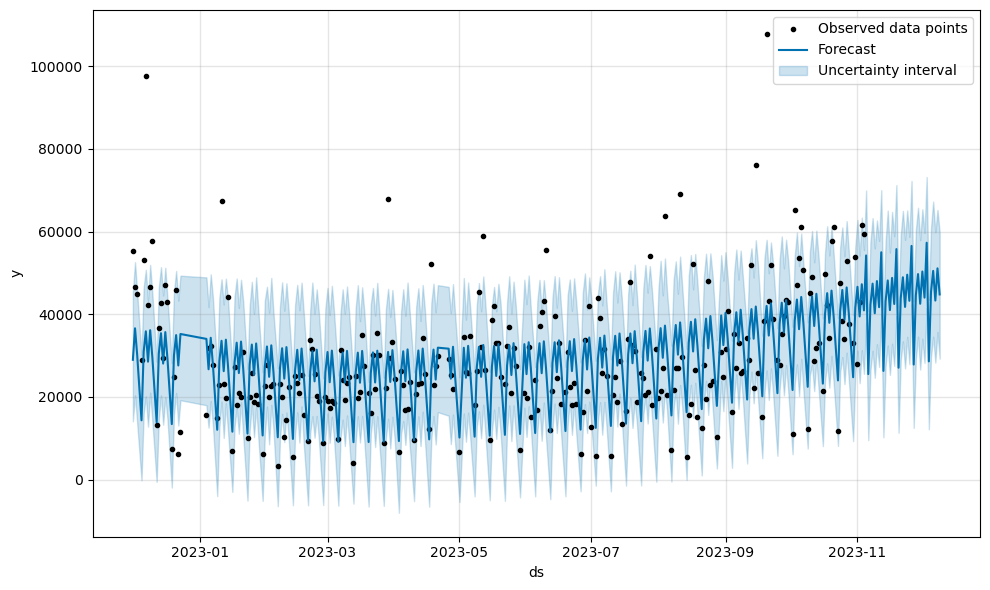

In [27]:
predicciones_plot = plot(modelo_prophet, predicciones_prophet, include_legend=True)

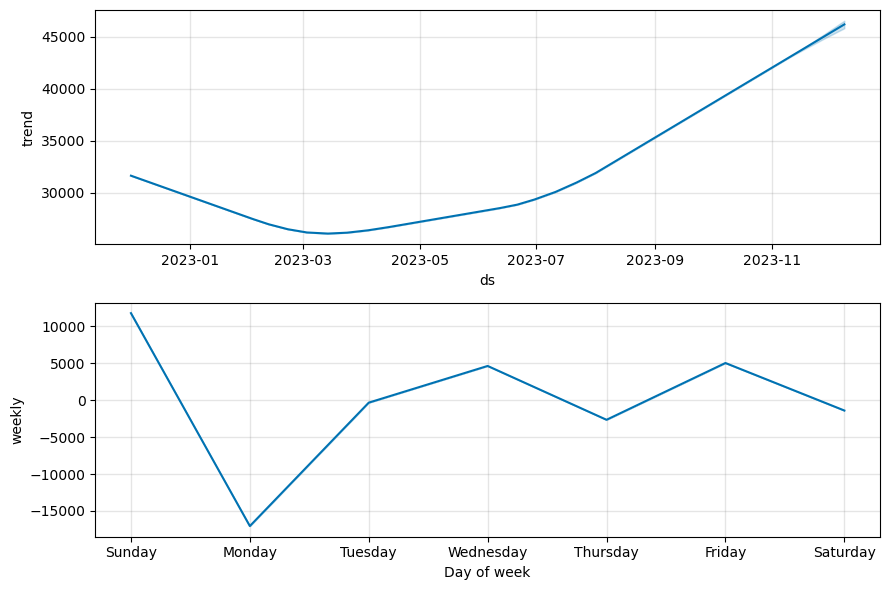

In [28]:
decompose_ = plot_components(modelo_prophet, predicciones_prophet)

##### XGBOOST (Extreme Gradient Boosting)
Es flexible, tiene un rendimiento consistente en problemas de series temporales y soporta control de regularización para evitar sobreajuste.

In [29]:
datos_xgb = ventas_globales.reset_index().rename(columns={'Date': 'fecha', 'TotalSales': 'ventas'})
datos_xgb.head()

,fecha,ventas
0,2022-12-01,55235.64
1,2022-12-02,46590.54
2,2022-12-03,44955.28
3,2022-12-05,28829.70
4,2022-12-06,53075.60


In [30]:
# Dividir en train y test
train_xgb, test_xgb = temporal_train_test_split(datos_xgb, test_size=30)
display(train_xgb.shape, train_xgb.head(2), train_xgb.tail(2))
display(test_xgb.shape, test_xgb.head(2), test_xgb.tail(2))

(275, 2)

,fecha,ventas
0,2022-12-01,55235.64
1,2022-12-02,46590.54


,fecha,ventas
273,2023-11-03,61512.43
274,2023-11-04,59347.73


(30, 2)

,fecha,ventas
275,2023-11-06,33570.41
276,2023-11-07,84536.81


,fecha,ventas
303,2023-12-08,79577.98
304,2023-12-09,28889.84


XGBoost no tiene capacidades de manejo directo de series temporales como Prophet, entonces debemos transformarlas en un problema de regresión supervisada.

In [31]:
def generar_caracteristicas(df, lags):
    df = df.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['ventas'].shift(lag)
    df['diff_1'] = df['ventas'].diff(1)
    df['day_of_week'] = df['fecha'].dt.dayofweek
    df['month'] = df['fecha'].dt.month
    return df
display(df.shape, df.head(2), df.tail(2))

(394330, 5)

,InvoiceNo,StockCode,Date,Country,TotalSales
0,536365,21730,2022-12-01,United Kingdom,25.5
1,536365,22752,2022-12-01,United Kingdom,15.3


,InvoiceNo,StockCode,Date,Country,TotalSales
394328,581587,23256,2023-12-09,France,16.60
394329,A563185,B,2023-08-12,United Kingdom,11062.06


In [32]:
train_xgb = generar_caracteristicas(train_xgb, lags=7)
test_xgb = generar_caracteristicas(test_xgb, lags=7)
display(train_xgb.shape, train_xgb.head(), train_xgb.tail())
display(test_xgb.shape, test_xgb.head(), test_xgb.tail())

(275, 12)

,fecha,ventas,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,diff_1,day_of_week,month
0,2022-12-01,55235.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,12
1,2022-12-02,46590.54,55235.64,NaN,NaN,NaN,NaN,NaN,NaN,-8645.10,4,12
2,2022-12-03,44955.28,46590.54,55235.64,NaN,NaN,NaN,NaN,NaN,-1635.26,5,12
3,2022-12-05,28829.70,44955.28,46590.54,55235.64,NaN,NaN,NaN,NaN,-16125.58,0,12
4,2022-12-06,53075.60,28829.70,44955.28,46590.54,55235.64,NaN,NaN,NaN,24245.90,1,12


,fecha,ventas,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,diff_1,day_of_week,month
270,2023-10-31,53866.75,33082.20,37605.91,52834.08,33889.88,38401.22,47659.07,11824.90,20784.55,1,10
271,2023-11-01,28026.92,53866.75,33082.20,37605.91,52834.08,33889.88,38401.22,47659.07,-25839.83,2,11
272,2023-11-02,43071.40,28026.92,53866.75,33082.20,37605.91,52834.08,33889.88,38401.22,15044.48,3,11
273,2023-11-03,61512.43,43071.40,28026.92,53866.75,33082.20,37605.91,52834.08,33889.88,18441.03,4,11
274,2023-11-04,59347.73,61512.43,43071.40,28026.92,53866.75,33082.20,37605.91,52834.08,-2164.70,5,11


(30, 12)

,fecha,ventas,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,diff_1,day_of_week,month
275,2023-11-06,33570.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,11
276,2023-11-07,84536.81,33570.41,NaN,NaN,NaN,NaN,NaN,NaN,50966.40,1,11
277,2023-11-08,55897.55,84536.81,33570.41,NaN,NaN,NaN,NaN,NaN,-28639.26,2,11
278,2023-11-09,64397.12,55897.55,84536.81,33570.41,NaN,NaN,NaN,NaN,8499.57,3,11
279,2023-11-10,68548.62,64397.12,55897.55,84536.81,33570.41,NaN,NaN,NaN,4151.50,4,11


,fecha,ventas,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,diff_1,day_of_week,month
300,2023-12-05,85237.87,23730.24,55683.80,49872.25,54065.98,66430.87,55289.61,19861.27,61507.63,1,12
301,2023-12-06,54802.27,85237.87,23730.24,55683.80,49872.25,54065.98,66430.87,55289.61,-30435.60,2,12
302,2023-12-07,72713.29,54802.27,85237.87,23730.24,55683.80,49872.25,54065.98,66430.87,17911.02,3,12
303,2023-12-08,79577.98,72713.29,54802.27,85237.87,23730.24,55683.80,49872.25,54065.98,6864.69,4,12
304,2023-12-09,28889.84,79577.98,72713.29,54802.27,85237.87,23730.24,55683.80,49872.25,-50688.14,5,12


In [33]:
display(train_xgb.isnull().sum())
display(test_xgb.isnull().sum())

fecha          0
ventas         0
lag_1          1
lag_2          2
lag_3          3
lag_4          4
lag_5          5
lag_6          6
lag_7          7
diff_1         1
day_of_week    0
month          0
dtype: int64

fecha          0
ventas         0
lag_1          1
lag_2          2
lag_3          3
lag_4          4
lag_5          5
lag_6          6
lag_7          7
diff_1         1
day_of_week    0
month          0
dtype: int64

In [34]:
# Eliminar valores NaN
train_xgb = train_xgb.dropna()
test_xgb = test_xgb.dropna()

In [35]:
X_train = train_xgb.drop(columns=['fecha', 'ventas'])
y_train = train_xgb['ventas']
X_test = test_xgb.drop(columns=['fecha', 'ventas'])
y_test = test_xgb['ventas']

In [36]:
modelo_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1)

modelo_xgb.fit(X_train, y_train)
y_pred = modelo_xgb.predict(X_test)

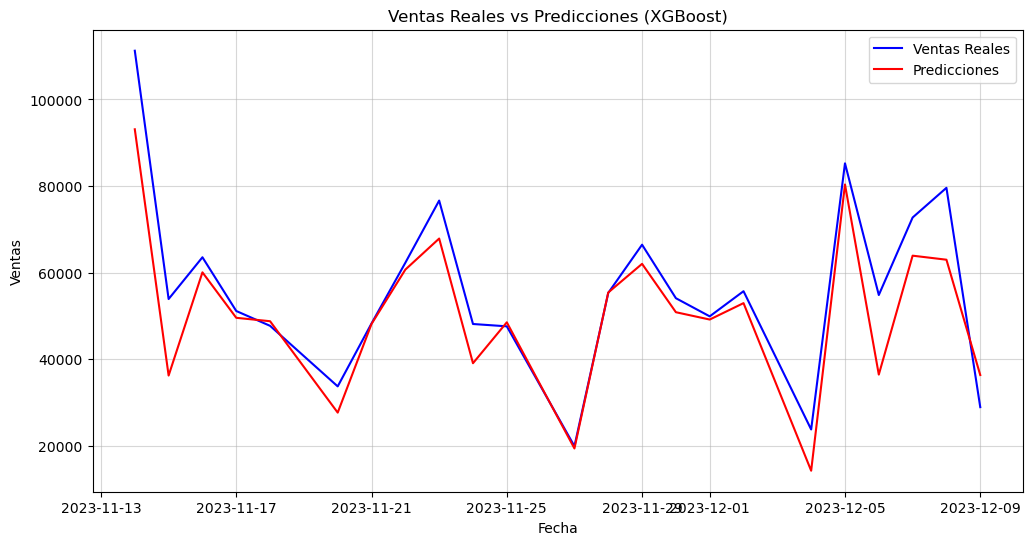

In [37]:
# Gráfica de valores reales vs predicciones
plt.figure(figsize=(12, 6))
plt.plot(test_xgb['fecha'], y_test, label='Ventas Reales', color='blue')
plt.plot(test_xgb['fecha'], y_pred, label='Predicciones', color='red')
plt.title('Ventas Reales vs Predicciones (XGBoost)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

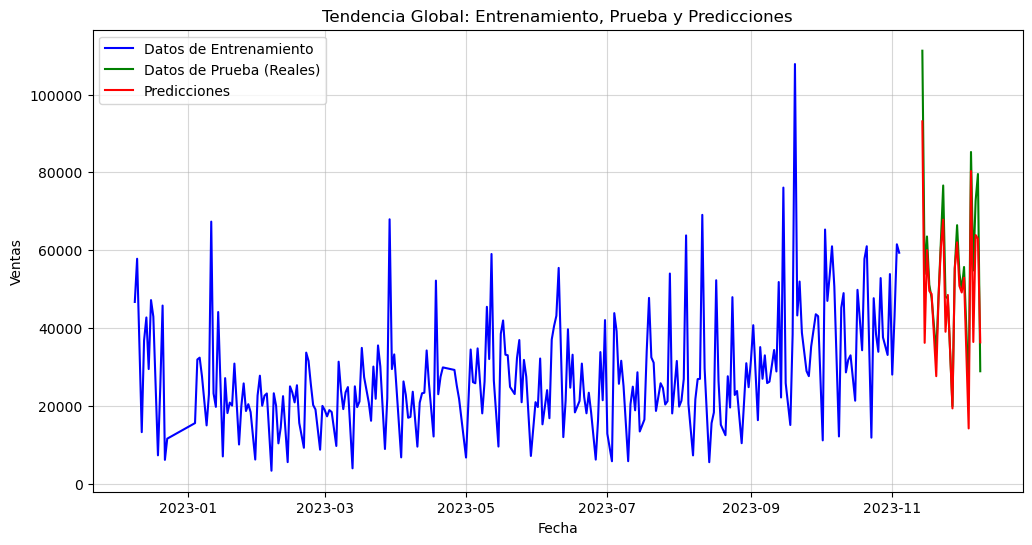

In [38]:
# Gráfica de tendencia global
plt.figure(figsize=(12, 6))
plt.plot(train_xgb['fecha'], train_xgb['ventas'], label='Datos de Entrenamiento', color='blue')
plt.plot(test_xgb['fecha'], y_test, label='Datos de Prueba (Reales)', color='green')
plt.plot(test_xgb['fecha'], y_pred, label='Predicciones', color='red')
plt.title('Tendencia Global: Entrenamiento, Prueba y Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()


## 3. Análisis de Resultados y Selección de Modelo

#### Serie temporal global (todos los países)

##### PROPHET

In [39]:
full_train_df = pd.merge(datos_train, predicciones_limpio, on='ds', how='left')
full_test_df = pd.merge(datos_test, predicciones_limpio, on='ds', how='left')
display(full_train_df.shape, full_train_df.head(2), full_train_df.tail(2))
display(full_test_df.shape, full_test_df.head(2), full_test_df.tail(2))

(275, 5)

,ds,y,yhat,yhat_lower,yhat_upper
0,2022-12-01,55235.64,28975.060476,14087.275798,45307.228482
1,2022-12-02,46590.54,36594.774361,20362.837444,52609.076224


,ds,y,yhat,yhat_lower,yhat_upper
273,2023-11-03,61512.43,47256.441326,31312.306777,63375.458396
274,2023-11-04,59347.73,40937.590799,25571.933932,55514.655304


(30, 5)

,ds,y,yhat,yhat_lower,yhat_upper
0,2023-11-06,33570.41,25515.315577,9516.257795,40737.225357
1,2023-11-07,84536.81,42330.996567,26490.866771,57534.309103


,ds,y,yhat,yhat_lower,yhat_upper
28,2023-12-08,79577.98,51106.702426,35697.073778,65243.287719
29,2023-12-09,28889.84,44787.851900,29251.426628,59880.159229


Error Medio Absoluto (_Mean Absolute Error - MAE_)

In [40]:
mae_prophet_train = mean_absolute_error(y_pred = full_train_df['yhat'], y_true = full_train_df['y'])
mae_prophet_train

8822.642901850117

In [41]:
mae_prophet_test = mean_absolute_error(y_pred = full_test_df['yhat'], y_true = full_test_df['y'])
mae_prophet_test

15699.857451888978

Error cuadrático medio (_Root Mean Squared Error - RMSE_)

In [42]:
rmse_prophet_train = np.sqrt(mean_squared_error(y_pred = full_train_df['yhat'], y_true = full_train_df['y']))
rmse_prophet_train

12069.31032598329

In [43]:
rmse_prophet_test = np.sqrt(mean_squared_error(y_pred = full_test_df['yhat'], y_true = full_test_df['y']))
rmse_prophet_test

21647.26644350424

Error porcentual absoluto medio (_Mean Absolute Percentage Error - MAPE_)

In [44]:
mape_prophet_train = mean_absolute_percentage_error(y_pred = full_train_df['yhat'], y_true = full_train_df['y'])
mape_prophet_train

0.36772643601922844

In [45]:
mape_prophet_test = mean_absolute_percentage_error(y_pred = full_test_df['yhat'], y_true = full_test_df['y'])
mape_prophet_test

0.25340605090373164

El MAPE en el conjunto de test (25,3%) es mejor que en el conjunto de train (36,8%). Las diferencias significativas entre las métricas de train y test (MAE y RMSE) sugieren que el modelo podría estar sobreajustando los datos de train.

##### XGBOOST

In [46]:
display(X_train.shape, X_train.head(2), X_train.tail(2))
display(y_train.shape, y_train.head(2), y_train.tail(2))
display(X_test.shape, X_test.head(2), X_test.tail(2))
display(y_test.shape, y_test.head(2), y_test.tail(2))

(268, 10)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,diff_1,day_of_week,month
7,42117.80,97632.87,53075.60,28829.7,44955.28,46590.54,55235.64,4580.91,4,12
8,46698.71,42117.80,97632.87,53075.6,28829.70,44955.28,46590.54,11104.30,5,12


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,diff_1,day_of_week,month
273,43071.40,28026.92,53866.75,33082.20,37605.91,52834.08,33889.88,18441.03,4,11
274,61512.43,43071.40,28026.92,53866.75,33082.20,37605.91,52834.08,-2164.70,5,11


(268,)

7    46698.71
8    57803.01
Name: ventas, dtype: float64

273    61512.43
274    59347.73
Name: ventas, dtype: float64

(23, 10)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,diff_1,day_of_week,month
282,32051.98,52891.30,68548.62,64397.12,55897.55,84536.81,33570.41,79212.42,1,11
283,111264.40,32051.98,52891.30,68548.62,64397.12,55897.55,84536.81,-57390.78,2,11


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,diff_1,day_of_week,month
303,72713.29,54802.27,85237.87,23730.24,55683.80,49872.25,54065.98,6864.69,4,12
304,79577.98,72713.29,54802.27,85237.87,23730.24,55683.80,49872.25,-50688.14,5,12


(23,)

282    111264.40
283     53873.62
Name: ventas, dtype: float64

303    79577.98
304    28889.84
Name: ventas, dtype: float64

In [47]:
mae_xgboost = mean_absolute_error(y_test, y_pred)
rmse_xgboost = np.sqrt(mean_squared_error(y_test, y_pred))
mape_xgboost = mean_absolute_percentage_error(y_test, y_pred)

print(f"MAE: {mae_xgboost}")
print(f"RMSE: {rmse_xgboost}")
print(f"MAPE: {mape_xgboost}")

MAE: 6344.963082540763
RMSE: 8742.378414350173
MAPE: 0.11870263666532926


El modelo XGBoost muestra un buen rendimiento con un MAPE de 11,9% lo que indica que las predicciones están cerca de los valores reales.

##### Comparación y selección de modelos
Métricas comunes:
- Mean Absolute Error (MAE): Mide el error absoluto promedio.
- Root Mean Squared Error (RMSE): Penaliza errores más grandes.
- Mean Absolute Percentage Error (MAPE): Mide el error relativo como porcentaje.

In [48]:
resultados_prophet = {
    'Modelo': 'Prophet',
    'MAE': mae_prophet_test,
    'RMSE': rmse_prophet_test,
    'MAPE': mape_prophet_test}

resultados_xgboost = {
    'Modelo': 'XGBoost',
    'MAE': mae_xgboost,
    'RMSE': rmse_xgboost,
    'MAPE': mape_xgboost,}

tabla_comparativa = pd.DataFrame([resultados_prophet, resultados_xgboost])
tabla_comparativa


,Modelo,MAE,RMSE,MAPE
0,Prophet,15699.857452,21647.266444,0.253406
1,XGBoost,6344.963083,8742.378414,0.118703


Seleccionamos el modelo con el menor MAPE y MAE, ya que indican mayor precisión en las predicciones.

In [49]:
mejor_modelo = tabla_comparativa.loc[tabla_comparativa['MAPE'].idxmin()]
print("\nModelo seleccionado basado en MAPE:")
print(mejor_modelo)


Modelo seleccionado basado en MAPE:
Modelo        XGBoost
MAE       6344.963083
RMSE      8742.378414
MAPE         0.118703
Name: 1, dtype: object


XGBOOST mostró mejores resultados en términos de menor error de predicción. Esto significa que el modelo logra capturar mejor las variaciones en las ventas, reduciendo la incertidumbre en la estimación del próximo mes.

##### Predicción global del próximo mes

In [50]:
fechas_futuras = pd.date_range(start='2023-12-10', periods=30, freq='D')
datos_futuros = pd.DataFrame({'fecha': fechas_futuras})
print(datos_futuros)

        fecha
0  2023-12-10
1  2023-12-11
2  2023-12-12
3  2023-12-13
4  2023-12-14
5  2023-12-15
6  2023-12-16
7  2023-12-17
8  2023-12-18
9  2023-12-19
10 2023-12-20
11 2023-12-21
12 2023-12-22
13 2023-12-23
14 2023-12-24
15 2023-12-25
16 2023-12-26
17 2023-12-27
18 2023-12-28
19 2023-12-29
20 2023-12-30
21 2023-12-31
22 2024-01-01
23 2024-01-02
24 2024-01-03
25 2024-01-04
26 2024-01-05
27 2024-01-06
28 2024-01-07
29 2024-01-08


In [51]:
datos_futuros['lag_1'] = np.nan
datos_futuros['lag_2'] = np.nan
datos_futuros['lag_3'] = np.nan
datos_futuros['lag_4'] = np.nan
datos_futuros['lag_5'] = np.nan
datos_futuros['lag_6'] = np.nan
datos_futuros['lag_7'] = np.nan
datos_futuros['diff_1'] = np.nan
print(datos_futuros.head())

       fecha  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  diff_1
0 2023-12-10    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN
1 2023-12-11    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN
2 2023-12-12    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN
3 2023-12-13    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN
4 2023-12-14    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN


In [52]:
ultimo_registro = test_xgb.iloc[-1]
print(ultimo_registro.head())

fecha     2023-12-09 00:00:00
ventas               28889.84
lag_1                79577.98
lag_2                72713.29
lag_3                54802.27
Name: 304, dtype: object


In [53]:
datos_futuros.loc[0, 'lag_1'] = ultimo_registro['lag_1']
datos_futuros.loc[0, 'lag_2'] = ultimo_registro['lag_2']
datos_futuros.loc[0, 'lag_3'] = ultimo_registro['lag_3']
datos_futuros.loc[0, 'lag_4'] = ultimo_registro['lag_4']
datos_futuros.loc[0, 'lag_5'] = ultimo_registro['lag_5']
datos_futuros.loc[0, 'lag_6'] = ultimo_registro['lag_6']
datos_futuros.loc[0, 'lag_7'] = ultimo_registro['lag_7']
datos_futuros.loc[0, 'diff_1'] = datos_futuros.loc[0, 'lag_1'] - datos_futuros.loc[0, 'lag_2']
print(datos_futuros.head())

       fecha     lag_1     lag_2     lag_3     lag_4     lag_5    lag_6  \
0 2023-12-10  79577.98  72713.29  54802.27  85237.87  23730.24  55683.8   
1 2023-12-11       NaN       NaN       NaN       NaN       NaN      NaN   
2 2023-12-12       NaN       NaN       NaN       NaN       NaN      NaN   
3 2023-12-13       NaN       NaN       NaN       NaN       NaN      NaN   
4 2023-12-14       NaN       NaN       NaN       NaN       NaN      NaN   

      lag_7   diff_1  
0  49872.25  6864.69  
1       NaN      NaN  
2       NaN      NaN  
3       NaN      NaN  
4       NaN      NaN  


In [54]:
datos_futuros['day_of_week'] = datos_futuros['fecha'].dt.dayofweek
datos_futuros['month'] = datos_futuros['fecha'].dt.month
print(datos_futuros.head())

       fecha     lag_1     lag_2     lag_3     lag_4     lag_5    lag_6  \
0 2023-12-10  79577.98  72713.29  54802.27  85237.87  23730.24  55683.8   
1 2023-12-11       NaN       NaN       NaN       NaN       NaN      NaN   
2 2023-12-12       NaN       NaN       NaN       NaN       NaN      NaN   
3 2023-12-13       NaN       NaN       NaN       NaN       NaN      NaN   
4 2023-12-14       NaN       NaN       NaN       NaN       NaN      NaN   

      lag_7   diff_1  day_of_week  month  
0  49872.25  6864.69            6     12  
1       NaN      NaN            0     12  
2       NaN      NaN            1     12  
3       NaN      NaN            2     12  
4       NaN      NaN            3     12  


In [55]:
X_futuro = datos_futuros.loc[0:0, ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'diff_1', 'day_of_week', 'month']]
print("Datos para la primera predicción:")
print(X_futuro)
prediccion = modelo_xgb.predict(X_futuro)[0]
datos_futuros.loc[0, 'prediccion'] = prediccion
print(datos_futuros.head())

Datos para la primera predicción:
      lag_1     lag_2     lag_3     lag_4     lag_5    lag_6     lag_7  \
0  79577.98  72713.29  54802.27  85237.87  23730.24  55683.8  49872.25   

    diff_1  day_of_week  month  
0  6864.69            6     12  
       fecha     lag_1     lag_2     lag_3     lag_4     lag_5    lag_6  \
0 2023-12-10  79577.98  72713.29  54802.27  85237.87  23730.24  55683.8   
1 2023-12-11       NaN       NaN       NaN       NaN       NaN      NaN   
2 2023-12-12       NaN       NaN       NaN       NaN       NaN      NaN   
3 2023-12-13       NaN       NaN       NaN       NaN       NaN      NaN   
4 2023-12-14       NaN       NaN       NaN       NaN       NaN      NaN   

      lag_7   diff_1  day_of_week  month    prediccion  
0  49872.25  6864.69            6     12  64268.074219  
1       NaN      NaN            0     12           NaN  
2       NaN      NaN            1     12           NaN  
3       NaN      NaN            2     12           NaN  
4       NaN    

In [56]:
# Lags para la segunda fila (siguiente fecha futura)
datos_futuros.loc[1, 'lag_1'] = datos_futuros.loc[0, 'prediccion']
datos_futuros.loc[1, 'lag_2'] = datos_futuros.loc[0, 'lag_1']
datos_futuros.loc[1, 'lag_3'] = datos_futuros.loc[0, 'lag_2']
datos_futuros.loc[1, 'lag_4'] = datos_futuros.loc[0, 'lag_3']
datos_futuros.loc[1, 'lag_5'] = datos_futuros.loc[0, 'lag_4']
datos_futuros.loc[1, 'lag_6'] = datos_futuros.loc[0, 'lag_5']
datos_futuros.loc[1, 'lag_7'] = datos_futuros.loc[0, 'lag_6']
datos_futuros.loc[1, 'diff_1'] = datos_futuros.loc[1, 'lag_1'] - datos_futuros.loc[1, 'lag_2']
print(datos_futuros.head(2))

       fecha         lag_1     lag_2     lag_3     lag_4     lag_5     lag_6  \
0 2023-12-10  79577.980000  72713.29  54802.27  85237.87  23730.24  55683.80   
1 2023-12-11  64268.074219  79577.98  72713.29  54802.27  85237.87  23730.24   

      lag_7        diff_1  day_of_week  month    prediccion  
0  49872.25   6864.690000            6     12  64268.074219  
1  55683.80 -15309.905781            0     12           NaN  


In [57]:
# Realizar predicciones para todas las fechas futuras
for i in range(1, len(datos_futuros)):
    X_futuro = datos_futuros.loc[i:i, ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'diff_1', 'day_of_week', 'month']]
    if X_futuro.isnull().values.any():
        print(f"Fila {i} contiene valores NaN, no se puede predecir.")
        continue
    prediccion = modelo_xgb.predict(X_futuro)[0]
    datos_futuros.loc[i, 'prediccion'] = prediccion
    if i + 1 < len(datos_futuros):
        datos_futuros.loc[i + 1, 'lag_1'] = prediccion
        datos_futuros.loc[i + 1, 'lag_2'] = datos_futuros.loc[i, 'lag_1']
        datos_futuros.loc[i + 1, 'lag_3'] = datos_futuros.loc[i, 'lag_2']
        datos_futuros.loc[i + 1, 'lag_4'] = datos_futuros.loc[i, 'lag_3']
        datos_futuros.loc[i + 1, 'lag_5'] = datos_futuros.loc[i, 'lag_4']
        datos_futuros.loc[i + 1, 'lag_6'] = datos_futuros.loc[i, 'lag_5']
        datos_futuros.loc[i + 1, 'lag_7'] = datos_futuros.loc[i, 'lag_6']
        datos_futuros.loc[i + 1, 'diff_1'] = datos_futuros.loc[i + 1, 'lag_1'] - datos_futuros.loc[i + 1, 'lag_2']

print(datos_futuros)

        fecha         lag_1         lag_2         lag_3         lag_4  \
0  2023-12-10  79577.980000  72713.290000  54802.270000  85237.870000   
1  2023-12-11  64268.074219  79577.980000  72713.290000  54802.270000   
2  2023-12-12  36312.906250  64268.074219  79577.980000  72713.290000   
3  2023-12-13  21231.160156  36312.906250  64268.074219  79577.980000   
4  2023-12-14  21235.857422  21231.160156  36312.906250  64268.074219   
5  2023-12-15  23780.798828  21235.857422  21231.160156  36312.906250   
6  2023-12-16  21146.738281  23780.798828  21235.857422  21231.160156   
7  2023-12-17  18295.343750  21146.738281  23780.798828  21235.857422   
8  2023-12-18  17569.886719  18295.343750  21146.738281  23780.798828   
9  2023-12-19  11743.286133  17569.886719  18295.343750  21146.738281   
10 2023-12-20  10054.209961  11743.286133  17569.886719  18295.343750   
11 2023-12-21  11698.817383  10054.209961  11743.286133  17569.886719   
12 2023-12-22  13197.079102  11698.817383  10054.20

In [58]:
df_predicciones = datos_futuros[['fecha', 'prediccion']]
print(df_predicciones.head())


       fecha    prediccion
0 2023-12-10  64268.074219
1 2023-12-11  36312.906250
2 2023-12-12  21231.160156
3 2023-12-13  21235.857422
4 2023-12-14  23780.798828


In [59]:
df_predicciones.to_csv('predicciones_globales_xgboost.csv', index=False)
print("Archivo 'predicciones_xgboost.csv' guardado exitosamente.\n\
Este archivo contiene las predicciones de ventas globales para los próximos 30 días.")

Archivo 'predicciones_xgboost.csv' guardado exitosamente.
Este archivo contiene las predicciones de ventas globales para los próximos 30 días.


##### Predicción por país: United Kingdom

In [60]:
ventas_agrupadas_paises = df.groupby(['Country', 'Date'], observed=False)['TotalSales'].sum().reset_index()
print(ventas_agrupadas_paises.head())

   Country       Date  TotalSales
0  Belgium 2022-12-01         0.0
1  Belgium 2022-12-02         0.0
2  Belgium 2022-12-03       304.9
3  Belgium 2022-12-05         0.0
4  Belgium 2022-12-06         0.0


In [61]:
fechas_futuras_uk = pd.date_range(start='2023-12-10', periods=30, freq='D')
datos_futuros_uk = pd.DataFrame({'fecha': fechas_futuras_uk})
print(datos_futuros_uk)

        fecha
0  2023-12-10
1  2023-12-11
2  2023-12-12
3  2023-12-13
4  2023-12-14
5  2023-12-15
6  2023-12-16
7  2023-12-17
8  2023-12-18
9  2023-12-19
10 2023-12-20
11 2023-12-21
12 2023-12-22
13 2023-12-23
14 2023-12-24
15 2023-12-25
16 2023-12-26
17 2023-12-27
18 2023-12-28
19 2023-12-29
20 2023-12-30
21 2023-12-31
22 2024-01-01
23 2024-01-02
24 2024-01-03
25 2024-01-04
26 2024-01-05
27 2024-01-06
28 2024-01-07
29 2024-01-08


In [62]:
# Obtener los últimos 7 registros de United Kingdom
ultimos_dias_uk = ventas_agrupadas_paises[ventas_agrupadas_paises['Country'] == 'United Kingdom'].tail(7)
print(ultimos_dias_uk)

             Country       Date  TotalSales
3043  United Kingdom 2023-12-02    52457.62
3044  United Kingdom 2023-12-04    21039.26
3045  United Kingdom 2023-12-05    83274.82
3046  United Kingdom 2023-12-06    51767.13
3047  United Kingdom 2023-12-07    54270.50
3048  United Kingdom 2023-12-08    77242.10
3049  United Kingdom 2023-12-09    26956.27


In [63]:
# Lags con los últimos valores conocidos
for i in range(len(ultimos_dias_uk)):
    datos_futuros_uk.loc[0, f'lag_{i+1}'] = ultimos_dias_uk.iloc[-(i+1)]['TotalSales']

datos_futuros_uk.loc[0, 'diff_1'] = datos_futuros_uk.loc[0, 'lag_1'] - datos_futuros_uk.loc[0, 'lag_2']
print(datos_futuros_uk.head())

       fecha     lag_1    lag_2    lag_3     lag_4     lag_5     lag_6  \
0 2023-12-10  26956.27  77242.1  54270.5  51767.13  83274.82  21039.26   
1 2023-12-11       NaN      NaN      NaN       NaN       NaN       NaN   
2 2023-12-12       NaN      NaN      NaN       NaN       NaN       NaN   
3 2023-12-13       NaN      NaN      NaN       NaN       NaN       NaN   
4 2023-12-14       NaN      NaN      NaN       NaN       NaN       NaN   

      lag_7    diff_1  
0  52457.62 -50285.83  
1       NaN       NaN  
2       NaN       NaN  
3       NaN       NaN  
4       NaN       NaN  


In [64]:
datos_futuros_uk['day_of_week'] = datos_futuros_uk['fecha'].dt.dayofweek
datos_futuros_uk['month'] = datos_futuros_uk['fecha'].dt.month
print(datos_futuros_uk.head())

       fecha     lag_1    lag_2    lag_3     lag_4     lag_5     lag_6  \
0 2023-12-10  26956.27  77242.1  54270.5  51767.13  83274.82  21039.26   
1 2023-12-11       NaN      NaN      NaN       NaN       NaN       NaN   
2 2023-12-12       NaN      NaN      NaN       NaN       NaN       NaN   
3 2023-12-13       NaN      NaN      NaN       NaN       NaN       NaN   
4 2023-12-14       NaN      NaN      NaN       NaN       NaN       NaN   

      lag_7    diff_1  day_of_week  month  
0  52457.62 -50285.83            6     12  
1       NaN       NaN            0     12  
2       NaN       NaN            1     12  
3       NaN       NaN            2     12  
4       NaN       NaN            3     12  


In [66]:
# Predicciones
X_fila_0 = datos_futuros_uk.loc[0:0, ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'diff_1', 'day_of_week', 'month']]
datos_futuros_uk.loc[0, 'prediccion'] = modelo_xgb.predict(X_fila_0)[0]

In [67]:
datos_futuros_uk.loc[1, 'lag_1'] = datos_futuros_uk.loc[0, 'prediccion']
datos_futuros_uk.loc[1, 'lag_2'] = datos_futuros_uk.loc[0, 'lag_1']
datos_futuros_uk.loc[1, 'lag_3'] = datos_futuros_uk.loc[0, 'lag_2']
datos_futuros_uk.loc[1, 'lag_4'] = datos_futuros_uk.loc[0, 'lag_3']
datos_futuros_uk.loc[1, 'lag_5'] = datos_futuros_uk.loc[0, 'lag_4']
datos_futuros_uk.loc[1, 'lag_6'] = datos_futuros_uk.loc[0, 'lag_5']
datos_futuros_uk.loc[1, 'lag_7'] = datos_futuros_uk.loc[0, 'lag_6']
datos_futuros_uk.loc[1, 'diff_1'] = datos_futuros_uk.loc[1, 'lag_1'] - datos_futuros_uk.loc[1, 'lag_2']

In [68]:
X_fila_1 = datos_futuros_uk.loc[1:1, ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'diff_1', 'day_of_week', 'month']]
datos_futuros_uk.loc[1, 'prediccion'] = modelo_xgb.predict(X_fila_1)[0]

In [69]:
for i in range(2, 30):
    datos_futuros_uk.loc[i, 'lag_1'] = datos_futuros_uk.loc[i-1, 'prediccion']
    datos_futuros_uk.loc[i, 'lag_2'] = datos_futuros_uk.loc[i-1, 'lag_1']
    datos_futuros_uk.loc[i, 'lag_3'] = datos_futuros_uk.loc[i-1, 'lag_2']
    datos_futuros_uk.loc[i, 'lag_4'] = datos_futuros_uk.loc[i-1, 'lag_3']
    datos_futuros_uk.loc[i, 'lag_5'] = datos_futuros_uk.loc[i-1, 'lag_4']
    datos_futuros_uk.loc[i, 'lag_6'] = datos_futuros_uk.loc[i-1, 'lag_5']
    datos_futuros_uk.loc[i, 'lag_7'] = datos_futuros_uk.loc[i-1, 'lag_6']
    datos_futuros_uk.loc[i, 'diff_1'] = datos_futuros_uk.loc[i, 'lag_1'] - datos_futuros_uk.loc[i, 'lag_2']

    X_fila_i = datos_futuros_uk.loc[i:i, ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'diff_1', 'day_of_week', 'month']]
    datos_futuros_uk.loc[i, 'prediccion'] = modelo_xgb.predict(X_fila_i)[0]

print(datos_futuros_uk)

        fecha         lag_1         lag_2         lag_3         lag_4  \
0  2023-12-10  26956.270000  77242.100000  54270.500000  51767.130000   
1  2023-12-11  19934.509766  26956.270000  77242.100000  54270.500000   
2  2023-12-12  15786.061523  19934.509766  26956.270000  77242.100000   
3  2023-12-13  19838.179688  15786.061523  19934.509766  26956.270000   
4  2023-12-14  20867.132812  19838.179688  15786.061523  19934.509766   
5  2023-12-15  19859.210938  20867.132812  19838.179688  15786.061523   
6  2023-12-16  17859.300781  19859.210938  20867.132812  19838.179688   
7  2023-12-17  15495.047852  17859.300781  19859.210938  20867.132812   
8  2023-12-18  14841.618164  15495.047852  17859.300781  19859.210938   
9  2023-12-19  10217.157227  14841.618164  15495.047852  17859.300781   
10 2023-12-20  10597.262695  10217.157227  14841.618164  15495.047852   
11 2023-12-21  13361.445312  10597.262695  10217.157227  14841.618164   
12 2023-12-22  15937.983398  13361.445312  10597.26

In [72]:
df_predicciones_uk = datos_futuros_uk[['fecha', 'prediccion']]
print("Predicciones para United Kingdom:")
print(df_predicciones_uk)

Predicciones para United Kingdom:
        fecha    prediccion
0  2023-12-10  19934.509766
1  2023-12-11  15786.061523
2  2023-12-12  19838.179688
3  2023-12-13  20867.132812
4  2023-12-14  19859.210938
5  2023-12-15  17859.300781
6  2023-12-16  15495.047852
7  2023-12-17  14841.618164
8  2023-12-18  10217.157227
9  2023-12-19  10597.262695
10 2023-12-20  13361.445312
11 2023-12-21  15937.983398
12 2023-12-22  17020.269531
13 2023-12-23  17686.988281
14 2023-12-24  17686.988281
15 2023-12-25  12474.033203
16 2023-12-26  10330.968750
17 2023-12-27  11740.484375
18 2023-12-28  13363.121094
19 2023-12-29  15937.983398
20 2023-12-30  16840.072266
21 2023-12-31  17686.988281
22 2024-01-01  18343.542969
23 2024-01-02  20482.964844
24 2024-01-03  22050.617188
25 2024-01-04  22644.605469
26 2024-01-05  22644.605469
27 2024-01-06  21684.736328
28 2024-01-07  20735.404297
29 2024-01-08  17237.500000


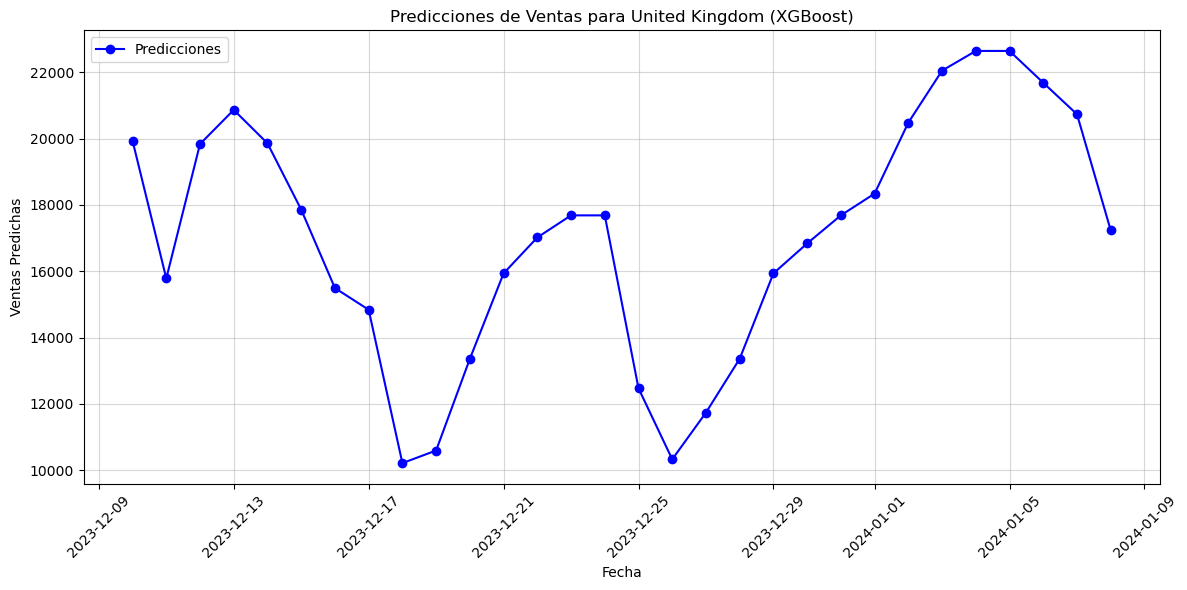

In [71]:
# Graficar las predicciones de ventas para United Kingdom
plt.figure(figsize=(12, 6))
plt.plot(df_predicciones_uk['fecha'], df_predicciones_uk['prediccion'], marker='o', linestyle='-', color='blue', label='Predicciones')
plt.title('Predicciones de Ventas para United Kingdom (XGBoost)')
plt.xlabel('Fecha')
plt.ylabel('Ventas Predichas')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

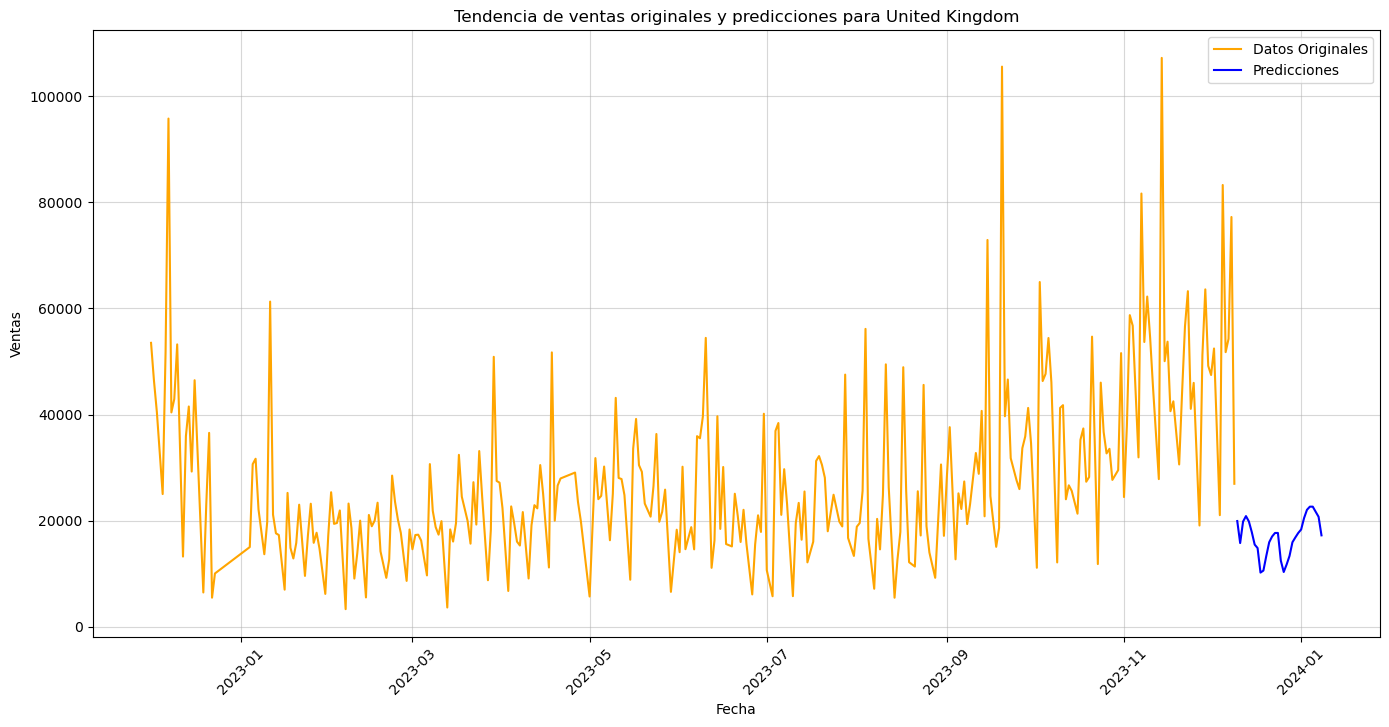

In [75]:
datos_originales_uk = df[df['Country'] == 'United Kingdom'].groupby('Date', as_index=False)['TotalSales'].sum()

# Graficar la tendencia de ventas real de United Kingdom junto con las predicciones
plt.figure(figsize=(14, 7))

plt.plot(datos_originales_uk['Date'], datos_originales_uk['TotalSales'], color='orange', label='Datos Originales')
plt.plot(df_predicciones_uk['fecha'], df_predicciones_uk['prediccion'], linestyle='-', color='blue', label='Predicciones')

plt.title('Tendencia de ventas originales y predicciones para United Kingdom')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()

In [76]:
df_predicciones_uk.to_csv('predicciones_uk_xgboost.csv', index=False)
print("Archivo 'predicciones_uk_xgboost.csv' guardado exitosamente.\n"
      "Este archivo contiene las predicciones de ventas para United Kingdom durante los próximos 30 días.")

Archivo 'predicciones_uk_xgboost.csv' guardado exitosamente.
Este archivo contiene las predicciones de ventas para United Kingdom durante los próximos 30 días.
